In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from utils import (
    detrend, monthly_anomalies,
    standardize, reg_slope, corr_with_ttest,
)

In [2]:
t_grid_file = xr.open_zarr('data/ORCA025.L46-KFS006_TroPA.zarr')

In [3]:
eq = dict(lat=0,lon=slice(140,260))

## Load input data 

### D20 

In [4]:
d20_mon_anom = monthly_anomalies(
    (-1) * t_grid_file.d20.sel(**eq)
).fillna(0.).compute()
d20_mon_anom.attrs.update({"long_name": "D20 anomaly", "units": "m", "positive": "up"})

### SSH 

In [5]:
ssh_o = t_grid_file.sossheig.sel(**eq)

ssh_mon_anom = monthly_anomalies(ssh_o)

ssh_mon_anom.attrs.update({"long_name": "SSH anomaly", "units": "m"})

### Correlation between SSH and D20

In [6]:
ds_a = xr.Dataset({"ssh": ssh_mon_anom,"d20":d20_mon_anom})

In [7]:
ds_dt_all = detrend(ds_a.compute())

In [8]:
corr_d20_ssh, corr_d20_ssh_low, corr_d20_ssh_up = corr_with_ttest((-1)*ds_dt_all.d20, ds_dt_all.ssh, sig=0.95)

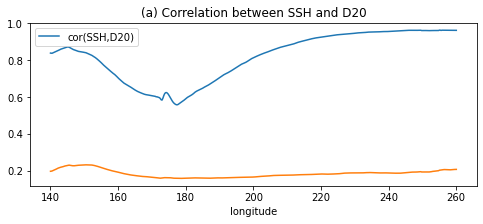

In [9]:
fig = plt.figure(figsize=(8,3))
corr_d20_ssh.plot(label='cor(SSH,D20)')
corr_d20_ssh_up.plot()
plt.title('(a) Correlation between SSH and D20')
plt.xlabel('longitude');
plt.legend()

### 21y-running regression coefficient

In [10]:
ds_dt = detrend(
    ds_a.rolling(time=21*12,center=True).construct("window_dim").dropna('time').compute(),
    dim='window_dim',
)

In [11]:
slope = -1*reg_slope(ds_dt.d20, ds_dt.ssh, dim="window_dim")

In [12]:
corr, c_low, c_up = corr_with_ttest(
    ds_dt.ssh, -1*ds_dt.d20, dim="window_dim"
)

In [13]:
non_sig = xr.where(np.abs(corr) <= c_up, 1., np.nan)

## Write output

In [14]:
!rm -rf data_figS6.zarr

xr.Dataset(
    dict(
        corr_d20_ssh=corr_d20_ssh,
        slope=slope,
        non_sig=non_sig,
    )
).to_zarr('data_figS6.zarr');